In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt

SEED = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)

In [ ]:
# inspiracja: https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/

In [ ]:
def generate_normal_vectors(mean, std_dev, size, dimension):
    A = np.random.normal(loc=mean, scale=std_dev, size=(size, dimension))
    B = np.random.normal(loc=mean, scale=std_dev, size=(size, dimension))
    return A, B

class SiameseNetworkDataset(Dataset):
    def __init__(self, vectors_A, vectors_B):
        self.vectors_A = vectors_A
        self.vectors_B = vectors_B


    def __len__(self):
        return len(self.vectors_A)

    def __getitem__(self, index):
        vector_A = torch.FloatTensor(self.vectors_A[index])
        vector_B = torch.FloatTensor(self.vectors_B[index])
        label = torch.norm(vector_A - vector_B)

        return vector_A, vector_B, label

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size):
        super(SiameseNetwork, self).__init__()

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )

    def forward(self, input1, input2):
        # In this function, we pass in both vectors and obtain both vectors
        # which are returned
        output1 = self.fc1(input1)
        output2 = self.fc1(input2)

        return output1, output2

In [ ]:
class SiameseLoss(nn.Module):
  # pomysł z funkcją contrastive loss
  # def __init__(self, margin=2.0):
  #     super(SiameseLoss, self).__init__()
  #     self.margin = margin

  # def forward(self, output1, output2, label):
  #   # Calculate the euclidean distance and calculate the contrastive loss
  #   euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

  #   loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
  #                                 (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


  #   return loss_contrastive
    def __init__(self):
        super(SiameseLoss, self).__init__()

    def forward(self, output1, output2, target):
        euclidean_distance = torch.sqrt(torch.sum(torch.pow(output1 - output2, 2), 1))
        loss = nn.MSELoss()(euclidean_distance, target)
        return loss

In [ ]:
# generowanie wektorów w przestrzeni DIM wymiarowej z liczbą próbek równą SIZE
DIM = 5
SIZE = 10000
vectors_A, vectors_B = generate_normal_vectors(0, 1, SIZE, DIM)
siamese_dataset = SiameseNetworkDataset(vectors_A, vectors_B)

# Testowanie dostępu do elementów w klasie Dataset
for i in range(3):
    sample = siamese_dataset[i]
    print("Wektor A:", sample[0])
    print("Wektor B:", sample[1])
    print("Etykieta:", sample[2])
    print("\n")


Wektor A: tensor([-0.2970,  1.8194,  0.6723, -0.5436,  0.2082])
Wektor B: tensor([-1.2174, -1.9320, -0.3307,  0.0312, -1.1086])
Etykieta: tensor(4.2415)


Wektor A: tensor([-0.4336, -2.4398, -0.2295, -0.1531, -1.5420])
Wektor B: tensor([ 0.8149, -0.2361,  1.6607, -0.6218,  0.0985])
Etykieta: tensor(3.5915)


Wektor A: tensor([ 0.7187,  0.0343, -1.3620,  0.5158,  0.9281])
Wektor B: tensor([-2.8004, -0.7567,  0.4151, -1.6915, -2.0897])
Etykieta: tensor(5.4906)




In [ ]:
# Podział na zbiór uczący, walidacyjny i testowy
dataset_size = len(siamese_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(siamese_dataset, [train_size, val_size, test_size])

# Indeksy dla SubsetRandomSampler
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, dataset_size))

# Samplery dla DataLoader
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# DataLoader
batch_size = 16
train_loader = DataLoader(siamese_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(siamese_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(siamese_dataset, batch_size=batch_size, sampler=test_sampler)


In [ ]:
net = SiameseNetwork(DIM).to(device)
criterion = SiameseLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:
counter = []
train_loss_history = []
val_loss_history = []
iteration_number = 0

# Iterate through the epochs
for epoch in range(50):

    # Training
    for i, (vec1, vec2, label) in enumerate(train_loader, 0):
        vec1, vec2, label = vec1.to(device), vec2.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = net(vec1, vec2)
        loss_siamese = criterion(output1, output2, label)
        loss_siamese.backward()
        optimizer.step()

    # Validation
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for i, (val_vec1, val_vec2, val_label) in enumerate(val_loader, 0):
            val_vec1, val_vec2, val_label = val_vec1.to(device), val_vec2.to(device), val_label.to(device)
            val_output1, val_output2 = net(val_vec1, val_vec2)
            val_loss += criterion(val_output1, val_output2, val_label).item()

    val_loss /= len(val_loader.dataset)  # Calculate the average validation loss
    net.train()  # Set the model back to training mode

    # Print and store training and validation loss every 10 epochs
    if (epoch+1) % 2 == 0 or epoch == 0:
        print(f"Epoch number {epoch+1:<5} Training loss {loss_siamese.item():.4f} Validation loss {val_loss:.4f}")
        iteration_number += 2
        counter.append(iteration_number)
        train_loss_history.append(loss_siamese.item())
        val_loss_history.append(val_loss)

test_loss = 0.0
with torch.no_grad():
    for i, (test_vec1, test_vec2, test_label) in enumerate(test_loader, 0):
        test_vec1, test_vec2, test_label = test_vec1.to(device), test_vec2.to(device), test_label.to(device)
        test_output1, test_output2 = net(test_vec1, test_vec2)
        test_loss += criterion(test_output1, test_output2, test_label).item()
print(f"\nTest loss {test_loss:.4f}")

# Plot the training and validation loss
plt.plot(counter, train_loss_history, label='Training Loss')
plt.plot(counter, val_loss_history, label='Validation Loss')
plt.legend()
plt.show()

Epoch 0 | Train Loss: 0.09828 | Val Loss: 0.11144
Epoch 2 | Train Loss: 0.03965 | Val Loss: 0.04076
Epoch 4 | Train Loss: 0.02538 | Val Loss: 0.01994
Epoch 6 | Train Loss: 0.01343 | Val Loss: 0.02086
Epoch 8 | Train Loss: 0.01152 | Val Loss: 0.02113
Epoch 10 | Train Loss: 0.00952 | Val Loss: 0.01275
Epoch 12 | Train Loss: 0.01035 | Val Loss: 0.01283
Epoch 14 | Train Loss: 0.00694 | Val Loss: 0.00792
Epoch 16 | Train Loss: 0.00793 | Val Loss: 0.00735
Epoch 18 | Train Loss: 0.00522 | Val Loss: 0.00737
Epoch 20 | Train Loss: 0.00556 | Val Loss: 0.00775
Epoch 22 | Train Loss: 0.00610 | Val Loss: 0.00739
Epoch 24 | Train Loss: 0.00460 | Val Loss: 0.01051
Epoch 26 | Train Loss: 0.00572 | Val Loss: 0.00929
Epoch 28 | Train Loss: 0.00453 | Val Loss: 0.00891
Epoch 30 | Train Loss: 0.00420 | Val Loss: 0.00570
Epoch 32 | Train Loss: 0.00272 | Val Loss: 0.00696
Epoch 34 | Train Loss: 0.00471 | Val Loss: 0.00654
Epoch 36 | Train Loss: 0.00371 | Val Loss: 0.00962
Epoch 38 | Train Loss: 0.00356 | Val

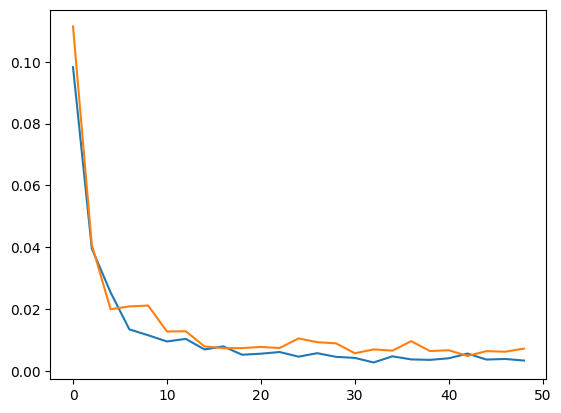

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt


DIM = 5
SEED = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)

def generate_normal_vectors(mean, std_dev, size, dimension):
    A = np.random.normal(loc=mean, scale=std_dev, size=(size, dimension))
    B = np.random.normal(loc=mean, scale=std_dev, size=(size, dimension))
    return A, B

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(DIM, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x2 = F.relu(self.fc1(x2))
        x2 = F.relu(self.fc2(x2))
        distance = torch.abs(x1 - x2)
        distance = self.fc3(distance)
        return distance

# Create an instance of the SiameseNetwork
siamese_net = SiameseNetwork()
siamese_net.to(device)

# Create a dataset class
class SiameseDataset(Dataset):
    def __init__(self, A, B):
        self.A = A
        self.B = B

    def __len__(self):
        return len(self.A)

    def __getitem__(self, idx):
        return self.A[idx], self.B[idx]


# Create a dataset instance
A, B = generate_normal_vectors(0, 1, 10000, DIM)
dataset = SiameseDataset(A, B)

# Split the dataset into train, test and validation sets
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(siamese_net.parameters(), lr=0.001)

# Train the model with validation every 10 epochs
num_epochs = 50

train_loss_list = []
val_loss_list = []
counter = []
for epoch in range(num_epochs):
    for A, B in train_loader:
        A = A.to(device).float()  # Convert A to float data type
        B = B.to(device).float()  # Convert B to float data type
        optimizer.zero_grad()
        outputs = siamese_net(A, B).squeeze()
        loss = criterion(outputs, torch.norm(A - B, dim=1))
        loss.backward()
        optimizer.step()
    if epoch % 2 == 0:
        with torch.no_grad():
            for A, B in val_loader:
                A = A.to(device).float()
                B = B.to(device).float()
                outputs = siamese_net(A, B).squeeze()
                val_loss = criterion(outputs, torch.norm(A - B, dim=1))
        counter.append(epoch)
        train_loss_list.append(loss.item())
        val_loss_list.append(val_loss.item())
        print(f'Epoch {epoch} | Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f}')

# Show charts
plt.plot(counter,train_loss_list, label='Train Loss')
plt.plot(counter,val_loss_list, label='Val Loss')

# Test the model
# Test the model
with torch.no_grad():
    for A, B in test_loader:
        A = A.to(device).float()
        B = B.to(device).float()
        outputs = siamese_net(A, B).squeeze()
        test_loss = criterion(outputs,  torch.norm(A - B, dim=1))
    print(f'Test Loss: {test_loss.item():.5f}')

In [ ]:
class KDTree(object):

    """
    A super short KD-Tree for points...
    so concise that you can copypasta into your homework
    without arousing suspicion.

    This implementation only supports Euclidean distance.

    The points can be any array-like type, e.g:
        lists, tuples, numpy arrays.

    Usage:
    1. Make the KD-Tree:
        `kd_tree = KDTree(points, dim)`
    2. You can then use `get_knn` for k nearest neighbors or
       `get_nearest` for the nearest neighbor

    points are be a list of points: [[0, 1, 2], [12.3, 4.5, 2.3], ...]
    """
    def __init__(self, points, dim,dist_sq_func=None):
        """Makes the KD-Tree for fast lookup.

        Parameters
        ----------
        points : list<point>
            A list of points.
        dim : int
            The dimension of the points.
        dist_sq_func : function(point, point), optional
            A function that returns the squared Euclidean distance
            between the two points.
            If omitted, it uses the default implementation.
        """

        if dist_sq_func is None:
            dist_sq_func = lambda a, b: sum((x - b[i]) ** 2
                for i, x in enumerate(a))

        def sort_tensor(t, col):
            return t[t[:,col].sort()[1]]
        def make(points, i=0):
            if len(points) > 1:
                sort_tensor(points,i)
                i = (i + 1) % dim
                m = len(points) >> 1
                return [make(points[:m], i), make(points[m + 1:], i),
                    points[m]]
            if len(points) == 1:
                return [None, None, points[0]]

        def add_point(node, point, i=0):
            if node is not None:
                dx = node[2][i] - point[i]
                for j, c in ((0, dx >= 0), (1, dx < 0)):
                    if c and node[j] is None:
                        node[j] = [None, None, point]
                    elif c:
                        add_point(node[j], point, (i + 1) % dim)

        import heapq
        def get_knn(node, point, k, return_dist_sq, heap, i=0, tiebreaker=1):
            if node is not None:
                dist_sq = dist_sq_func(point, node[2])
                dx = node[2][i] - point[i]
                if len(heap) < k:
                    heapq.heappush(heap, (-dist_sq, tiebreaker, node[2]))
                elif dist_sq < -heap[0][0]:
                    heapq.heappushpop(heap, (-dist_sq, tiebreaker, node[2]))
                i = (i + 1) % dim
                # Goes into the left branch, then the right branch if needed
                for b in (dx < 0, dx >= 0)[:1 + (dx * dx < -heap[0][0])]:
                    get_knn(node[b], point, k, return_dist_sq,
                        heap, i, (tiebreaker << 1) | b)
            if tiebreaker == 1:
                return [(-h[0], h[2]) if return_dist_sq else h[2]
                    for h in sorted(heap)][::-1]

        def walk(node):
            if node is not None:
                for j in 0, 1:
                    for x in walk(node[j]):
                        yield x
                yield node[2]
        self._add_point = add_point
        self._get_knn = get_knn
        self._root = make(points)
        self._walk = walk

    def __iter__(self):
        return self._walk(self._root)

    def add_point(self, point):
        """Adds a point to the kd-tree.

        Parameters
        ----------
        point : array-like
            The point.
        """
        if self._root is None:
            self._root = [None, None, point]
        else:
            self._add_point(self._root, point)

    def get_knn(self, point, k, return_dist_sq=True):
        """Returns k nearest neighbors.

        Parameters
        ----------
        point : array-like
            The point.
        k: int
            The number of nearest neighbors.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distances.

        Returns
        -------
        list<array-like>
            The nearest neighbors.
            If `return_dist_sq` is true, the return will be:
                [(dist_sq, point), ...]
            else:
                [point, ...]
        """
        return self._get_knn(self._root, point, k, return_dist_sq, [])

    def get_nearest(self, point, return_dist_sq=True):
        """Returns the nearest neighbor.

        Parameters
        ----------
        point : array-like
            The point.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distance.

        Returns
        -------
        array-like
            The nearest neighbor.
            If the tree is empty, returns `None`.
            If `return_dist_sq` is true, the return will be:
                (dist_sq, point)
            else:
                point
        """
        l = self._get_knn(self._root, point, 1, return_dist_sq, [])
        return l[0] if len(l) else None

In [ ]:
a = np.random.normal(loc=0, scale=1, size=(3,DIM))
#a = torch.tensor(a).to(device)

def dist_sq(a, b):
    return siamese_net(torch.tensor(a).float(), torch.tensor(b).float()).item()

In [ ]:
b = torch.tensor(a).to(device)
print(dist_sq(b[0].to(device), b[1].to(device)))
print(torch.norm(b[0]-b[1]).item())

1.7087277173995972
1.6930580002031852


<ipython-input-3-99beb0c5dffc>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return siamese_net(torch.tensor(a).float(), torch.tensor(b).float()).item()


In [ ]:
def sort_tensor(t, col):
    return t[t[:,col].sort()[1]]
print(b)
print(sort_tensor(b, 4))

tensor([[ 0.2000,  1.1227,  0.3647,  0.2223,  0.1345],
        [ 1.0494,  1.8829,  0.2816,  1.3538, -0.3945],
        [-1.7795, -0.2063,  1.9518, -1.1714, -0.5758]], device='cuda:0',
       dtype=torch.float64)
tensor([[-1.7795, -0.2063,  1.9518, -1.1714, -0.5758],
        [ 1.0494,  1.8829,  0.2816,  1.3538, -0.3945],
        [ 0.2000,  1.1227,  0.3647,  0.2223,  0.1345]], device='cuda:0',
       dtype=torch.float64)


In [ ]:
kd_tree = KDTree(points = b, dim = DIM,dist_sq_func=dist_sq)

In [ ]:
new_point = np.random.normal(loc=0, scale=1, size=(1,DIM))
print(new_point)
new_point = torch.tensor(new_point[0]).to(device)
kd_tree.add_point(new_point)

[[-0.88084321 -0.60894597  1.07332512  1.55747779 -0.72482855]]


In [ ]:
# KNN Classifier using KDTree
class KNNClassifier(object):
    def __init__(self, siamese_net, k=1):
        self.k = k
        self.kd_tree = None
        self.labels = None


    def dist_sq(a, b):
        return siamese_net(torch.tensor(a).float(), torch.tensor(b).float()).item()
    def fit(self, X, y):
        self.kd_tree = KDTree(X, X.shape[1])
        self.labels = y

    def predict(self, X):
        y_pred = []
        for x in X:
            neighbors = self.kd_tree.get_knn(x, self.k, return_dist_sq=False) #[label[..,..,..,..,..]]
            y_pred.append(np.argmax(np.bincount(self.labels[neighbors])))
        return np.array(y_pred)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

# Create a KNNClassifier instance
knn = KNNClassifier(k=3, siamese_net = siamese_net)


# test the classifier
a = np.random.normal(loc=0, scale=1, size=(100,DIM))
b = np.random.normal(loc=0, scale=1, size=(100,DIM))
X = np.concatenate((a, b), axis=0)
y = np.array([0]*100 + [1]*100)

X = torch.tensor(X).to(device).float()
y = torch.tensor(y).to(device)
knn.fit(X, y)
print(knn.score(X, y))

In [ ]:
'''
[[
   label,
   [1,2,3,4]
],
[
  label,
  [2,3,4,5]
]
]
'''

from sklearn.datasets import load_diabetes
import torch
import numpy as np

X, Y = load_diabetes(return_X_y=True)
dataset = []
for x, y in zip(X, Y):
    dataset.append(torch.nested.nested_tensor([torch.tensor(y).view(1,1), torch.tensor(x).view(X.shape[1],1)]))
dataset[0]

<ipython-input-7-8222a1f29c5c>:20: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  dataset.append(torch.nested.nested_tensor([torch.tensor(y).view(1,1), torch.tensor(x).view(X.shape[1],1)]))


nested_tensor([
  tensor([[151.]], dtype=torch.float64),
  tensor([[ 0.0381],
          [ 0.0507],
          [ 0.0617],
          [ 0.0219],
          [-0.0442],
          [-0.0348],
          [-0.0434],
          [-0.0026],
          [ 0.0199],
          [-0.0176]], dtype=torch.float64)
])